In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms as T
import cv2

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights)

c:\Users\Mihail\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  model.eval()
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

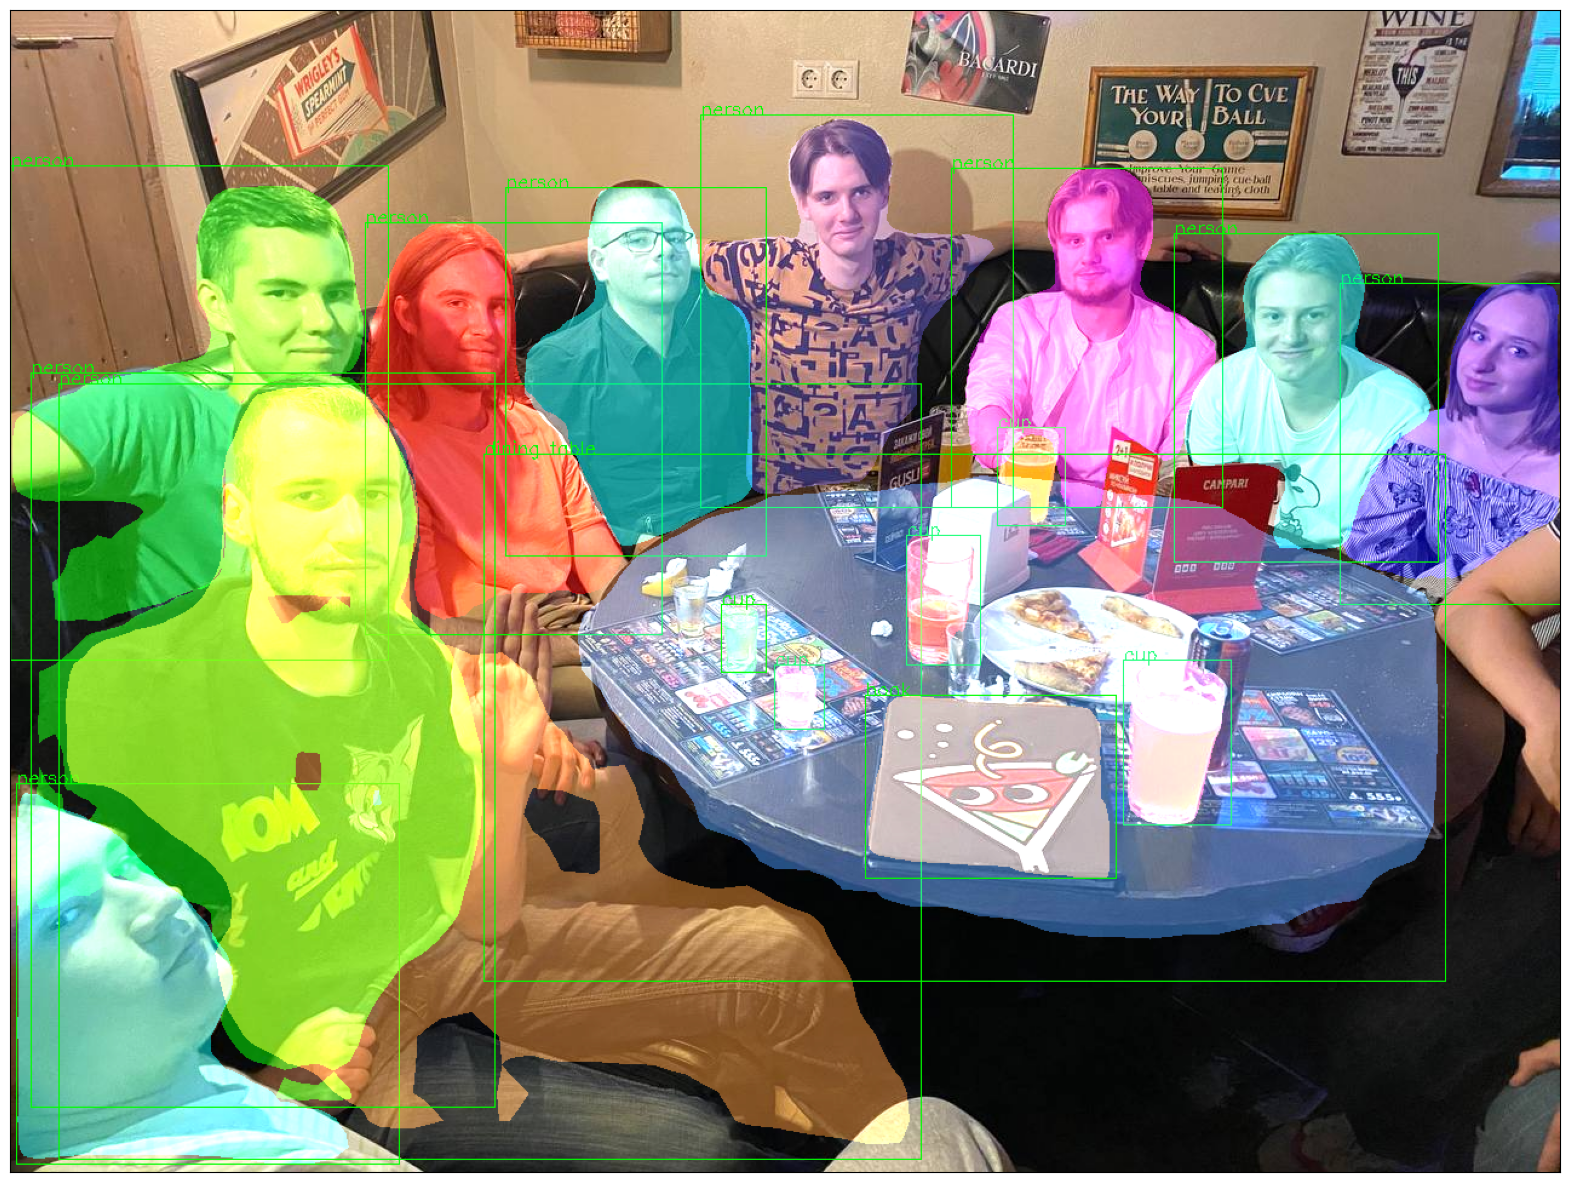

In [7]:
def random_colour_masks(image): # Takes a binary mask as input
      colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80,
                     190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
      # Extracting all the channels
      r = np.zeros_like(image).astype(np.uint8)
      g = np.zeros_like(image).astype(np.uint8)
      b = np.zeros_like(image).astype(np.uint8)
      # Assigning random colors to each instances of segmentation defferenciated by white  
      r[image == 1], g[image == 1], b[image == 1] = colours[int(np.random.uniform(0,10))]
      coloured_mask = np.stack([r, g, b], axis=2)

      return coloured_mask

# Visualization function
def instance_segmentation_api(img_path, threshold=0.5, text_th=1):
       masks, boxes, pred_cls = get_prediction(img_path, threshold)
       img = cv2.imread(img_path)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

       for i in range(len(masks)):
          rgb_mask = random_colour_masks(masks[i])
          img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0) # Blending image with coloured mask
          xmin,ymin,xmax,ymax=int(boxes[i][0][0]), int(boxes[i][0][1]),int(boxes[i][1][0]), int(boxes[i][1][1])
          cv2.rectangle(img, (xmin,ymin), (xmax+5,ymax-2), (0,255,0), 1)
          cv2.putText(img, pred_cls[i], (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), text_th)

       plt.figure(figsize=(20,30))
       plt.imshow(img)
       plt.xticks([])
       plt.yticks([])
       plt.show()

instance_segmentation_api("test_image.jpg", threshold=0.9)# Replace with your image path